# Overview

- title
- overview
- business understanding
- data understanding
- methodoligy
- data preperation
- exploritory data analysis
- model preperation
- model building and analysis
- conclusion
- summary
- index  

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('tweet_sentiment_records.csv', encoding = 'latin-1')

# Exploritory Data Analysis

In [3]:
df = df.rename(columns = {'tweet_text' : 'text', 
                          'emotion_in_tweet_is_directed_at': 'directed_to', 
                          'is_there_an_emotion_directed_at_a_brand_or_product' : 'emotion'})

In [4]:
df.head()

,text,directed_to,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
df['text'][4]

"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"

In [6]:
df.shape

(9093, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         9092 non-null   object
 1   directed_to  3291 non-null   object
 2   emotion      9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [8]:
df['emotion'].value_counts()

emotion
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

In [9]:
df[df['emotion'] == "I can't tell"]

,text,directed_to,emotion
90,Thanks to @mention for publishing the news of ...,NaN,I can't tell
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell
237,Just what America needs. RT @mention Google to...,NaN,I can't tell
341,The queue at the Apple Store in Austin is FOUR...,NaN,I can't tell
368,Hope it's better than wave RT @mention Buzz is...,NaN,I can't tell
...,...,...,...
9020,It's funny watching a room full of people hold...,NaN,I can't tell
9032,"@mention yeah, we have @mention , Google has n...",NaN,I can't tell
9037,"@mention Yes, the Google presentation was not ...",NaN,I can't tell
9058,&quot;Do you know what Apple is really good at...,NaN,I can't tell


In [73]:
df['emotion'] = df['emotion'].replace({"I can't tell" : 'unk',
                                       "No emotion toward brand or product" : "neutral",
                                      'Positive emotion' : 'positive',
                                      'Negative emotion' : 'negative'}) 

In [74]:
df['emotion'].value_counts()

emotion
neutral     5388
positive    2978
negative     570
unk          156
Name: count, dtype: int64

In [12]:
df[df['emotion'] == 'neutral'].head(1)

,text,directed_to,emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,neutral


In [13]:
df['text'][5]

'@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd'

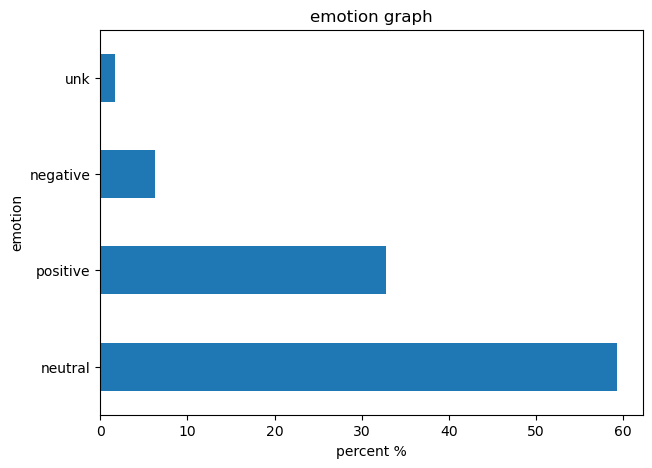

In [75]:
fig, ax = plt.subplots(figsize = (7,5)) # create figure
emotion_bar = df['emotion'].value_counts(normalize=True) * 100 # assign what values to count
emotion_bar.plot(kind='barh') # type of graph
ax.set_xlabel('percent %') # label y axis
ax.set_title('emotion graph') # title
plt.show(); # output

In [15]:
df['directed_to'].value_counts()

directed_to
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

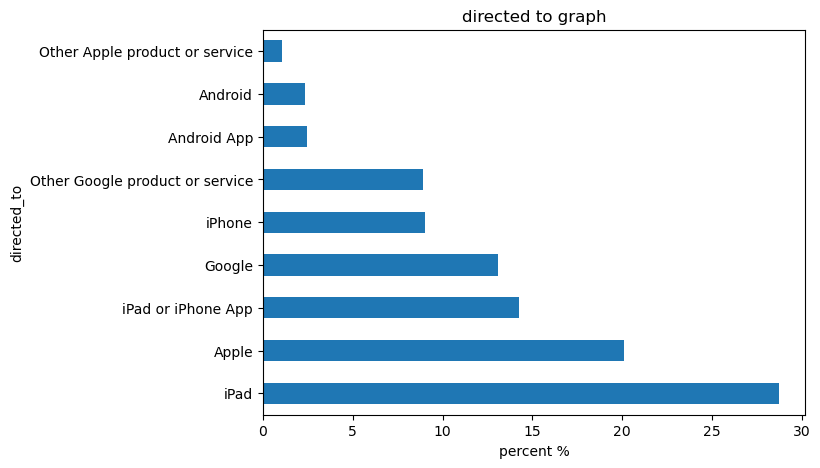

In [16]:
fig, ax = plt.subplots(figsize = (7,5)) # create figure
direction_bar = df['directed_to'].value_counts(normalize=True) * 100 # assign what values to count
direction_bar.plot(kind='barh') # type of graph
ax.set_xlabel('percent %') # label y axis
ax.set_title('directed to graph') # title
plt.show(); # output

In [17]:
df['text'][0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [18]:
len(df['text'][0].split())

23

In [19]:
df.loc[6]

text               NaN
directed_to        NaN
emotion        neutral
Name: 6, dtype: object

In [20]:
df['text'].isna().value_counts()

text
False    9092
True        1
Name: count, dtype: int64

In [21]:
df = df.drop(6, axis = 0)

In [22]:
def word_count(row):
    return len(str(row).split())

In [23]:
df['word_count'] = df['text'].apply(word_count)

In [24]:
df.head()

,text,directed_to,emotion,word_count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,23
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,22
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,15
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,15
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,17


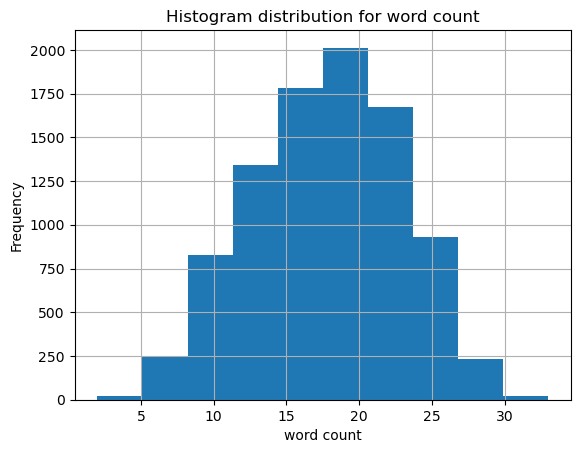

In [25]:
hist = df['word_count'].hist(bins = 10)
plt.title('Histogram distribution for word count') 
plt.xlabel('word count') 
plt.ylabel('Frequency')
plt.show();

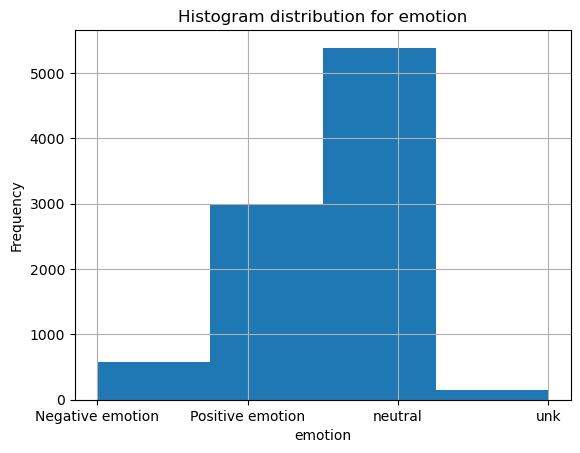

In [26]:
hist = df['emotion'].hist(bins = 4)
plt.title('Histogram distribution for emotion') 
plt.xlabel('emotion') 
plt.ylabel('Frequency')
plt.show();

In [78]:
def avg_word_count_per_emotion(emotion):
    em = emotion
    df_ = df[df['emotion'] == emotion]
    total = len(df_['word_count'])
    count = sum(df_['word_count'])
    avg = round(count / total)
    return (f'{emotion} emotion tweets have a total of {total} words, with an avg of {avg} words per tweet')

In [79]:
avg_word_count_per_emotion('negative')

'negative emotion tweets have a total of 570 words, with an avg of 19 words per tweet'

In [80]:
avg_word_count_per_emotion('positive')

'positive emotion tweets have a total of 2978 words, with an avg of 18 words per tweet'

In [81]:
avg_word_count_per_emotion('neutral')

'neutral emotion tweets have a total of 5388 words, with an avg of 17 words per tweet'

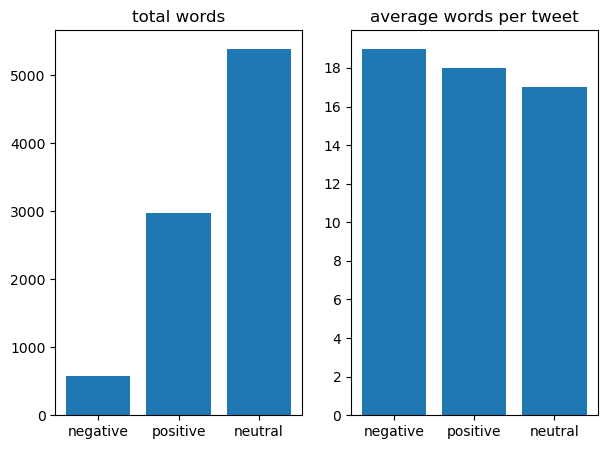

In [125]:
fig, ax = plt.subplots(1, 2, figsize = (7,5))

lables_0 = ['negative', 'positive', 'neutral'] 
ax[0].bar(height = [570, 2978, 5388], x = range(3), tick_label = lables_0)
ax[0].set_title('total words')

labels_1 = ['negative', 'positive', 'neutral']
ax[1].bar(height = [19, 18, 17], x = range(3), tick_label = labels_1)
ax[1].set_title('average words per tweet')
plt.locator_params(axis = 'y', nbins = 10)
plt.show();